# Data Wrangling

In [1]:
#datalink because github doesn't let me upload large files https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [2]:
import pandas as pd
import numpy as np

In [3]:
#load and check data
data_path = "/Users/carlriemann/Documents/data/"
train_file = data_path + "train.csv"
test_file = data_path + "test.csv"
stores_file = data_path + "stores.csv"
oil_file = data_path + "oil.csv"
holidays_file = data_path + "holidays_events.csv"

train_df = pd.read_csv(train_file, parse_dates=['date'])
test_df = pd.read_csv(test_file, parse_dates=['date'])
stores_df = pd.read_csv(stores_file)
oil_df = pd.read_csv(oil_file, parse_dates=['date'])
holidays_df = pd.read_csv(holidays_file, parse_dates=['date'])


print("Train DataFrame:")
print(train_df.head(), '\n')


print("Test DataFrame:")
print(test_df.head(), '\n')

      
print("Stores DataFrame:")
print(stores_df.head(), '\n')

print("Oil DataFrame:")
print(oil_df.head(), '\n')

print("Holidays DataFrame:")
print(holidays_df.head(), '\n')

Train DataFrame:
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0 

Test DataFrame:
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0 

Stores DataFrame:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3   

In [4]:
#check for missing values
print("Missing values in Train DataFrame:\n", train_df.isnull().sum(), '\n')
print("Missing values in Test DataFrame:\n", test_df.isnull().sum(), '\n')
print("Missing values in Stores DataFrame:\n", stores_df.isnull().sum(), '\n')
print("Missing values in Oil DataFrame:\n", oil_df.isnull().sum(), '\n')
print("Missing values in Holidays DataFrame:\n", holidays_df.isnull().sum(), '\n')

Missing values in Train DataFrame:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64 

Missing values in Test DataFrame:
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64 

Missing values in Stores DataFrame:
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64 

Missing values in Oil DataFrame:
 date           0
dcoilwtico    43
dtype: int64 

Missing values in Holidays DataFrame:
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64 



In [5]:
#fill "dcoilwtico" by linear interpolation, and forwardfill/backwardfill
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='linear')
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].ffill().bfill()

In [6]:
#fix holidays_df
transfer_holidays = holidays_df[holidays_df['type'] == 'Transfer']

#For each transfer holiday, find the corresponding original holiday where 'transferred' is True
for index, row in transfer_holidays.iterrows():
    #Find the original holiday row where transferred is True and the names match (looking for the word Traslado)
    original_holiday = holidays_df[(holidays_df['description'] == row['description'].replace("Traslado ", "")) & (holidays_df['transferred'] == True)]
    
    if not original_holiday.empty:
        #update the row where 'holiday_type' is 'Transfer' with info from the original holiday
        holidays_df.at[index, 'description'] = original_holiday['description'].values[0]
        holidays_df.at[index, 'date'] = row['date']  #keep the 'Transfer' holiday date
        holidays_df.at[index, 'type'] = 'TransferredHoliday'

# Step 3: Drop the 'transferred' column
holidays_df.drop(columns=['transferred'], inplace=True)

In [7]:
print("Missing values in Oil DataFrame:\n", oil_df.isnull().sum(), '\n')

Missing values in Oil DataFrame:
 date          0
dcoilwtico    0
dtype: int64 



In [8]:
#creating new date features columns
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['week_of_year'] = train_df['date'].dt.isocalendar().week

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['week_of_year'] = test_df['date'].dt.isocalendar().week

In [9]:
#Creating lag features for sales to capture recent trends.
train_df['lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

#Create rolling averages, help the model detect smoother trends
train_df['rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'], group_keys=False)['sales'] \
    .rolling(window=7).mean().reset_index(level=['store_nbr', 'family'], drop=True)

train_df['rolling_mean_30'] = train_df.groupby(['store_nbr', 'family'], group_keys=False)['sales'] \
    .rolling(window=30).mean().reset_index(level=['store_nbr', 'family'], drop=True)

#check the results
print(train_df[['sales', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']].head(10))

   sales  lag_1  lag_7  rolling_mean_7  rolling_mean_30
0    0.0    NaN    NaN             NaN              NaN
1    0.0    NaN    NaN             NaN              NaN
2    0.0    NaN    NaN             NaN              NaN
3    0.0    NaN    NaN             NaN              NaN
4    0.0    NaN    NaN             NaN              NaN
5    0.0    NaN    NaN             NaN              NaN
6    0.0    NaN    NaN             NaN              NaN
7    0.0    NaN    NaN             NaN              NaN
8    0.0    NaN    NaN             NaN              NaN
9    0.0    NaN    NaN             NaN              NaN


#REMEMBER NAN VALUES ARE ADDED TO DATES WITH NO past INFO

In [10]:
train_df['lag_1'] = train_df['lag_1'].ffill()
train_df['lag_7'] = train_df['lag_7'].ffill()
train_df['rolling_mean_7'] = train_df['rolling_mean_7'].ffill()
train_df['rolling_mean_30'] = train_df['rolling_mean_30'].ffill()
train_df['lag_1'] = train_df['lag_1'].ffill()
train_df['lag_7'] = train_df['lag_7'].ffill()
train_df['rolling_mean_7'] = train_df['rolling_mean_7'].ffill()
train_df['rolling_mean_30'] = train_df['rolling_mean_30'].ffill()

In [11]:
# Creating lag features for the test set
test_df['lag_1'] = test_df.groupby(['store_nbr', 'family'])['onpromotion'].shift(1)
test_df['lag_7'] = test_df.groupby(['store_nbr', 'family'])['onpromotion'].shift(7)

# Creating rolling statistics for the test set
test_df['rolling_mean_7'] = test_df.groupby(['store_nbr', 'family'], group_keys=False)['onpromotion'] \
    .rolling(window=7).mean().reset_index(level=['store_nbr', 'family'], drop=True)
test_df['rolling_mean_30'] = test_df.groupby(['store_nbr', 'family'], group_keys=False)['onpromotion'] \
    .rolling(window=30).mean().reset_index(level=['store_nbr', 'family'], drop=True)

# Forward fill any NaN values in the lag and rolling features for the test set
test_df['lag_1'] = test_df['lag_1'].ffill()
test_df['lag_7'] = test_df['lag_7'].ffill()
test_df['rolling_mean_7'] = test_df['rolling_mean_7'].ffill()
test_df['rolling_mean_30'] = test_df['rolling_mean_30'].ffill()
test_df['lag_1'] = test_df['lag_1'].bfill()
test_df['lag_7'] = test_df['lag_7'].bfill()
test_df['rolling_mean_7'] = test_df['rolling_mean_7'].bfill()
test_df['rolling_mean_30'] = test_df['rolling_mean_30'].bfill()

In [12]:
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)
print("Columns in holidays_df:", holidays_df.columns)
print("Columns in oil_df:", oil_df.columns)
print("Columns in stores_df:", stores_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30'],
      dtype='object')
Columns in holidays_df: Index(['date', 'type', 'locale', 'locale_name', 'description'], dtype='object')
Columns in oil_df: Index(['date', 'dcoilwtico'], dtype='object')
Columns in stores_df: Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')


In [13]:
train_df = train_df.merge(stores_df, on='store_nbr', how='left')
test_df = test_df.merge(stores_df, on='store_nbr', how='left')
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type',
       'cluster'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type',
       'cluster'],
      dtype='object')


In [14]:
train_df = train_df.merge(oil_df, on='date', how='left')
test_df = test_df.merge(oil_df, on='date', how='left')
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type', 'cluster',
       'dcoilwtico'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type', 'cluster',
       'dcoilwtico'],
      dtype='object')


In [15]:
#transferred TRUE/FALSE means if the holiday was transferred that year or not
train_df = train_df.merge(holidays_df[['date', 'type']], on='date', how='left')
test_df = test_df.merge(holidays_df[['date', 'type']], on='date', how='left')
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type_x',
       'cluster', 'dcoilwtico', 'type_y'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'type_x',
       'cluster', 'dcoilwtico', 'type_y'],
      dtype='object')


In [16]:
print(train_df)
print(test_df)

              id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3054343  3000883 2017-08-15          9                     POULTRY   438.133   
3054344  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3054345  3000885 2017-08-15          9                     PRODUCE  2419.729   
3054346  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3054347  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  year  month  day 

In [17]:
#rename type_x, type_y
train_df.rename(columns={'type_x': 'store_type', 'type_y': 'holiday_type'}, inplace=True)
test_df.rename(columns={'type_x': 'store_type', 'type_y': 'holiday_type'}, inplace=True)

# Check the column names after renaming
print(train_df)
print(test_df)

              id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3054343  3000883 2017-08-15          9                     POULTRY   438.133   
3054344  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3054345  3000885 2017-08-15          9                     PRODUCE  2419.729   
3054346  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3054347  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  year  month  day 

There is only 1 holiday date on the test set from the holidays_df dates, explaining why there are so many NaNs

In [18]:
test_df['holiday_type'].fillna('No Holiday', inplace=True)

In [19]:
#encode onpromotion, to represent if there was or wasn't a promotion
train_df['has_promotion'] = np.where(train_df['onpromotion'] > 0, 1, 0)
test_df['has_promotion'] = np.where(test_df['onpromotion'] > 0, 1, 0)

In [20]:
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

Columns in train_df: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'store_type',
       'cluster', 'dcoilwtico', 'holiday_type', 'has_promotion'],
      dtype='object')
Columns in test_df: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30', 'city', 'state', 'store_type',
       'cluster', 'dcoilwtico', 'holiday_type', 'has_promotion'],
      dtype='object')


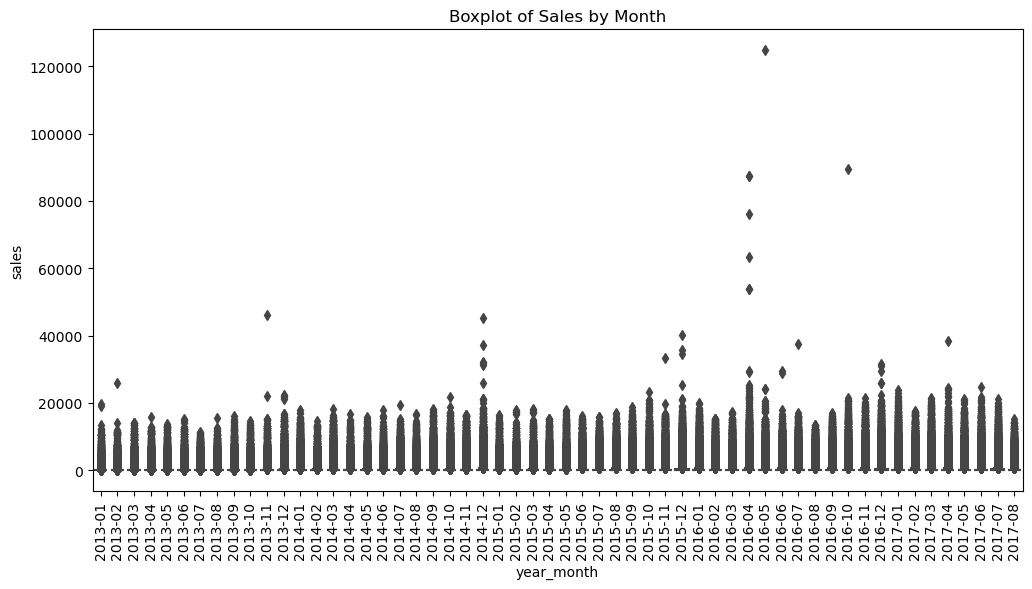

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df['year_month'] = train_df['date'].dt.to_period('M')

#create a boxplot of sales by year_month
plt.figure(figsize=(12, 6))
sns.boxplot(x='year_month', y='sales', data=train_df)
plt.xticks(rotation=90)
plt.title('Boxplot of Sales by Month')
plt.show()

# EDA

In [26]:
print("Missing values in train_df:")
print(train_df.isnull().sum())

print("\nMissing values in test_df:")
print(test_df.isnull().sum())

Missing values in train_df:
id                       0
date                     0
store_nbr                0
family                   0
sales                    0
onpromotion              0
year                     0
month                    0
day                      0
day_of_week              0
week_of_year             0
lag_1                 1782
lag_7                12474
rolling_mean_7       10692
rolling_mean_30      51678
city                     0
state                    0
store_type               0
cluster                  0
dcoilwtico               0
holiday_type       2551824
has_promotion            0
year_month               0
dtype: int64

Missing values in test_df:
id                     0
date                   0
store_nbr              0
family                 0
onpromotion            0
year                   0
month                  0
day                    0
day_of_week            0
week_of_year           0
lag_1                  0
lag_7                  0
rolling_me

In [25]:
#fill missing "dcoilwtico" in train_df by linear interpolation, forward fill, and backward fill
train_df['dcoilwtico'] = train_df['dcoilwtico'].interpolate(method='linear')
train_df['dcoilwtico'] = train_df['dcoilwtico'].ffill().bfill()

test_df['dcoilwtico'] = test_df['dcoilwtico'].interpolate(method='linear')
test_df['dcoilwtico'] = test_df['dcoilwtico'].ffill().bfill()

print(train_df['dcoilwtico'].isnull().sum())
print(test_df['dcoilwtico'].isnull().sum())

0
0


In [28]:
train_df['holiday_type'].fillna('No Holiday', inplace=True)
print(train_df['holiday_type'].isnull().sum())

0


In [29]:
#Option to fill NaN values
#train_df['lag_1'].fillna(method='ffill', inplace=True)
#train_df['lag_7'].fillna(method='ffill', inplace=True)
#train_df['rolling_mean_7'].fillna(method='ffill', inplace=True)
#train_df['rolling_mean_30'].fillna(method='ffill', inplace=True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


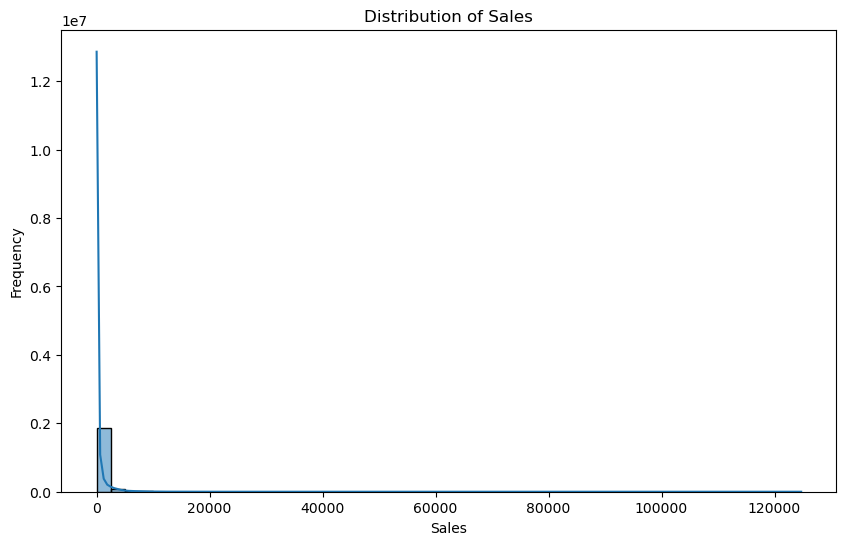

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


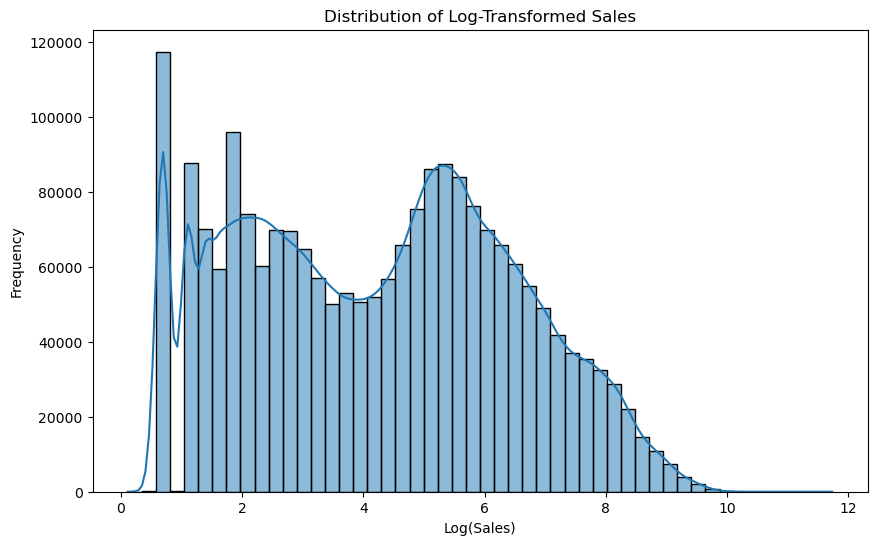

In [32]:
#use log for better distribution
train_df['log_sales'] = np.log1p(train_df['sales'])

#check for any inf or NaN values after the transformation
train_df = train_df.replace([np.inf, -np.inf], np.nan)
train_df = train_df.dropna(subset=['log_sales'])

#filter out small sales
train_df = train_df[train_df['sales'] > 0]


plt.figure(figsize=(10, 6))
sns.histplot(train_df['log_sales'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Sales')
plt.xlabel('Log(Sales)')
plt.ylabel('Frequency')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


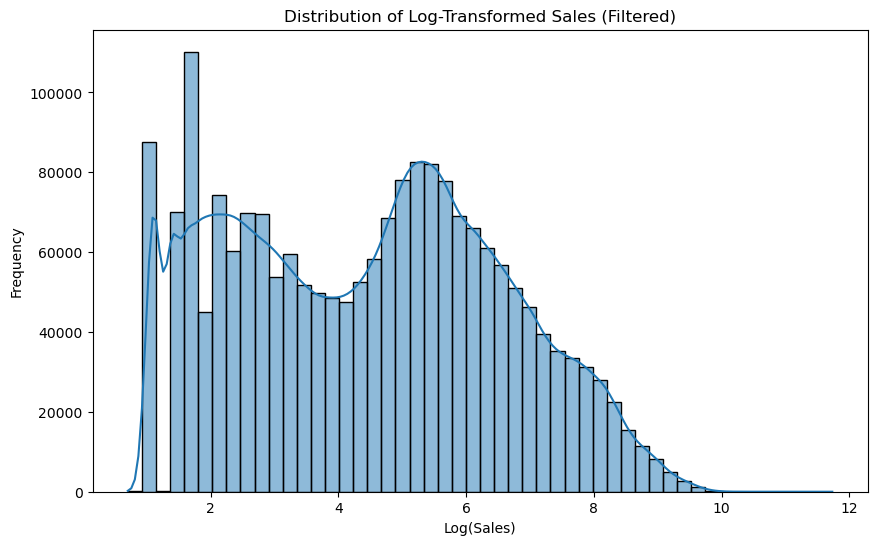

In [33]:
#filter out less small sales
train_df = train_df[train_df['sales'] > 1]

plt.figure(figsize=(10, 6))
sns.histplot(train_df['log_sales'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Sales (Filtered)')
plt.xlabel('Log(Sales)')
plt.ylabel('Frequency')
plt.show()

There are still a lot of small values. There is a peak at 6, which is equal to 403 units sold. Then the tail drops which is expected indicating larger sales are rarer.

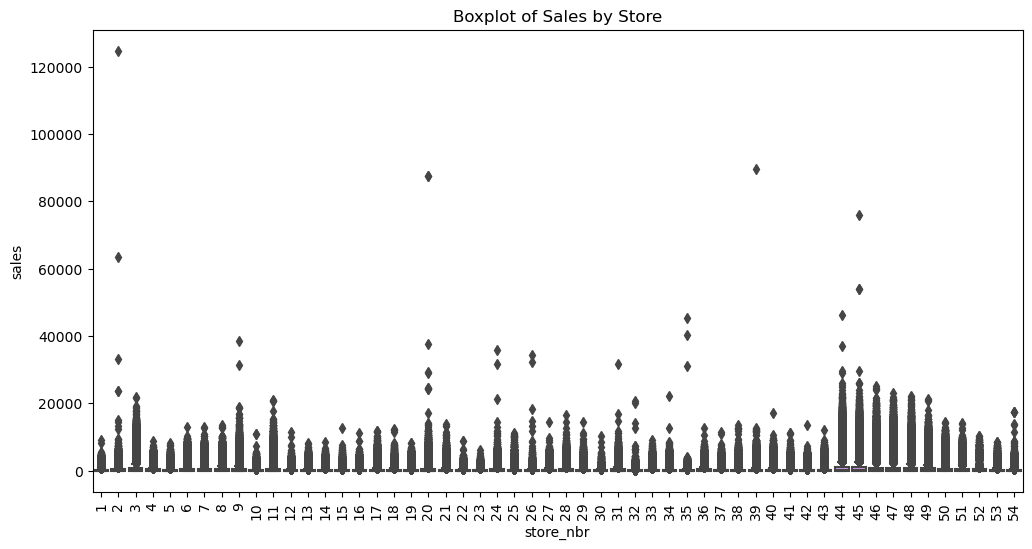

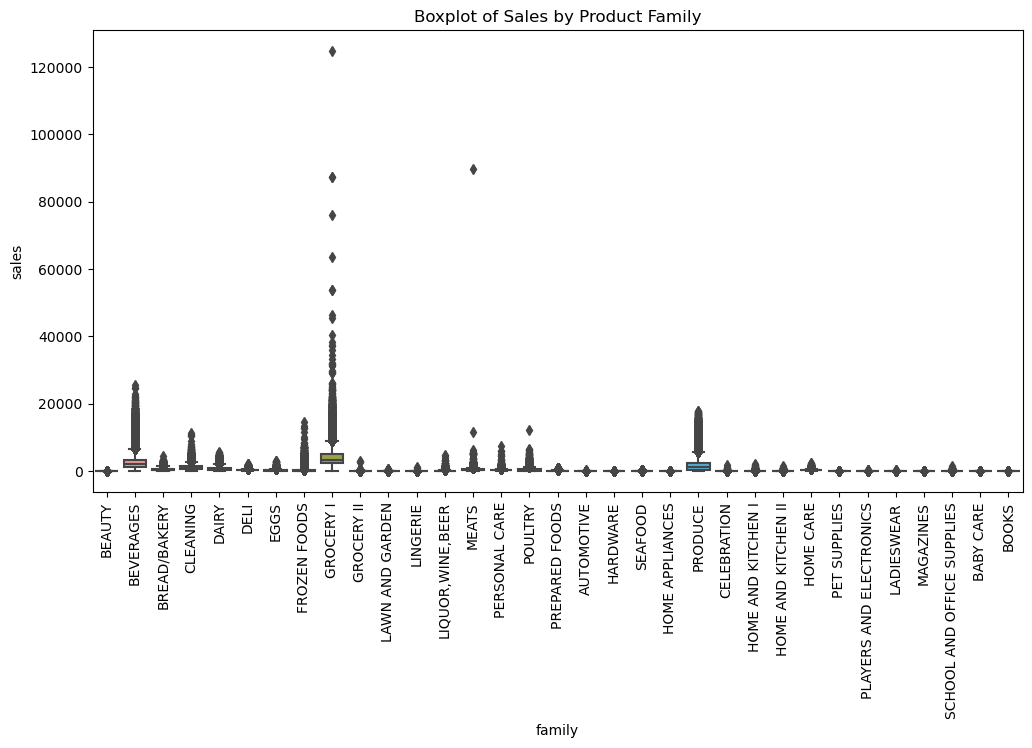

In [35]:
#boxplot of sales by store_nbr
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_nbr', y='sales', data=train_df)
plt.title('Boxplot of Sales by Store')
plt.xticks(rotation=90)
plt.show()

#boxplot of sales by family
plt.figure(figsize=(12, 6))
sns.boxplot(x='family', y='sales', data=train_df)
plt.title('Boxplot of Sales by Product Family')
plt.xticks(rotation=90)
plt.show()

2nd graph: Low median, likely that most sales are concentrated in a few key families. There are some outliers in Meats, Poultry. 


1st graph: Stores 44 to 49 have the biggest sales. Low median. Lots of outliers for different stores, maybe promotions, or holidays.


In [42]:
top_stores_info = stores_df[stores_df['store_nbr'].isin([44, 45, 46, 47, 48, 49])]

#print the relevant information for top stores
print("Information for Stores 44, 45, 46, 47, 48, 49:")
print(top_stores_info[['store_nbr', 'city', 'state', 'type', 'cluster']])

Information for Stores 44, 45, 46, 47, 48, 49:
    store_nbr   city      state type  cluster
43         44  Quito  Pichincha    A        5
44         45  Quito  Pichincha    A       11
45         46  Quito  Pichincha    A       14
46         47  Quito  Pichincha    A       14
47         48  Quito  Pichincha    A       14
48         49  Quito  Pichincha    A       11


The stores with the most sales are located in the capital city of Ecuador.

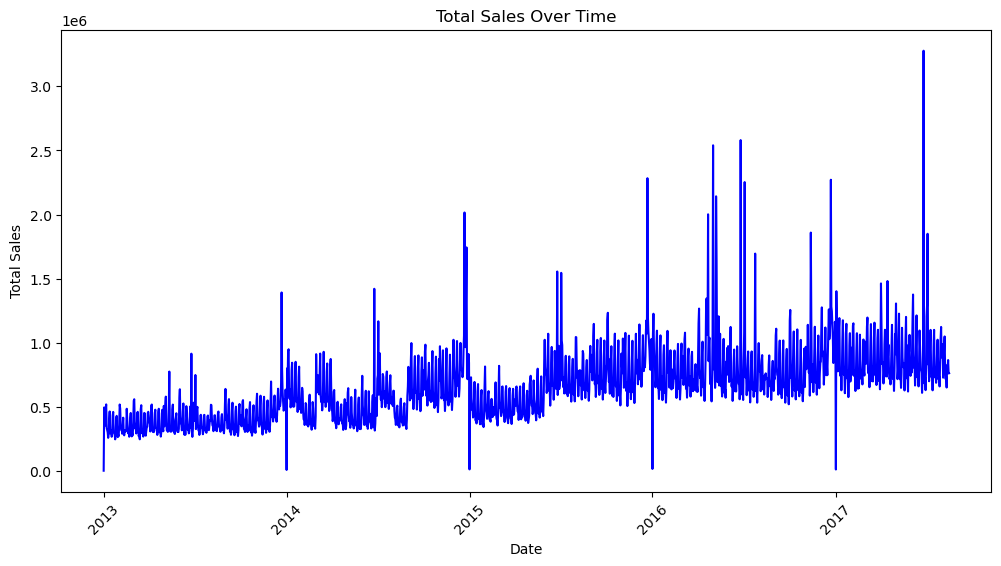

In [36]:
sales_by_date = train_df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['date'], sales_by_date['sales'], color='blue')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

There are some big spikes in the graph, indicating holidays/events. In April 2016 there was an earthquake in Ecuador, so there are some spikes there.

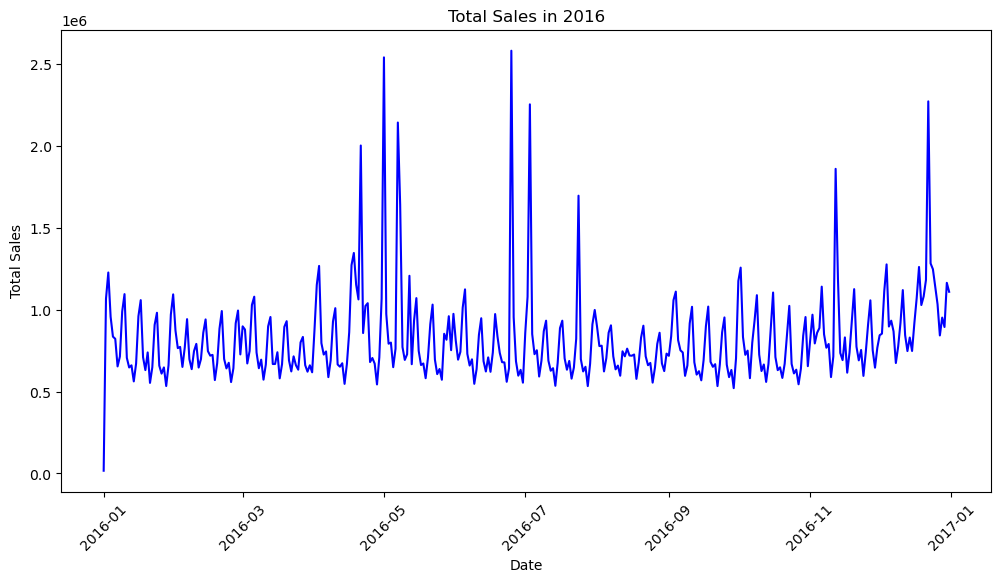

In [43]:
train_df['date'] = pd.to_datetime(train_df['date'])

#filter data for the year 2016
train_2016 = train_df[train_df['date'].dt.year == 2016]

#group by date and sum the sales for each date in 2016
sales_by_date_2016 = train_2016.groupby('date')['sales'].sum().reset_index()

#plot the total sales over time for 2016
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date_2016['date'], sales_by_date_2016['sales'], color='blue')
plt.title('Total Sales in 2016')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

People bought so much stuff during the earthquake, to keep in stock or donate, that stores ran out of inventory.

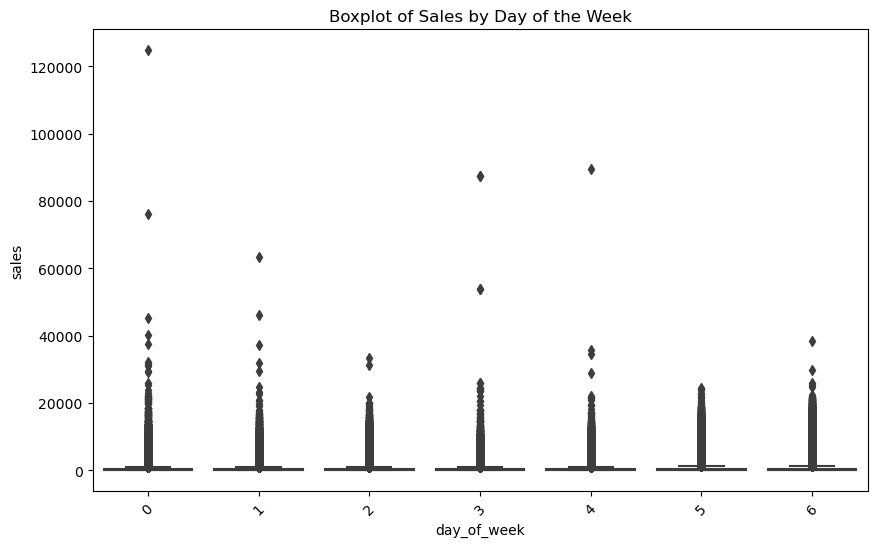

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='sales', data=train_df)
plt.title('Boxplot of Sales by Day of the Week')
plt.xticks(rotation=45)
plt.show()

Some days have very high outliers. The boxes for all days of the week are concentrated near the bottom of the plot, meaning most stores have relatively low sales on an average day. Monday and Sunday are the days with the most sales.

In [45]:
outliers_df = train_df[train_df['sales'] > 80000]

print(outliers_df[['date', 'day_of_week', 'sales']])

              date  day_of_week       sales
2171292 2016-04-21            3   87438.516
2171293 2016-04-21            3   87438.516
2194017 2016-05-02            0  124717.000
2488752 2016-10-07            4   89576.360


All the dates are close to the earthquake. We might need to analyze if we should remove the year of the earthquake or not for our final analysis/model.

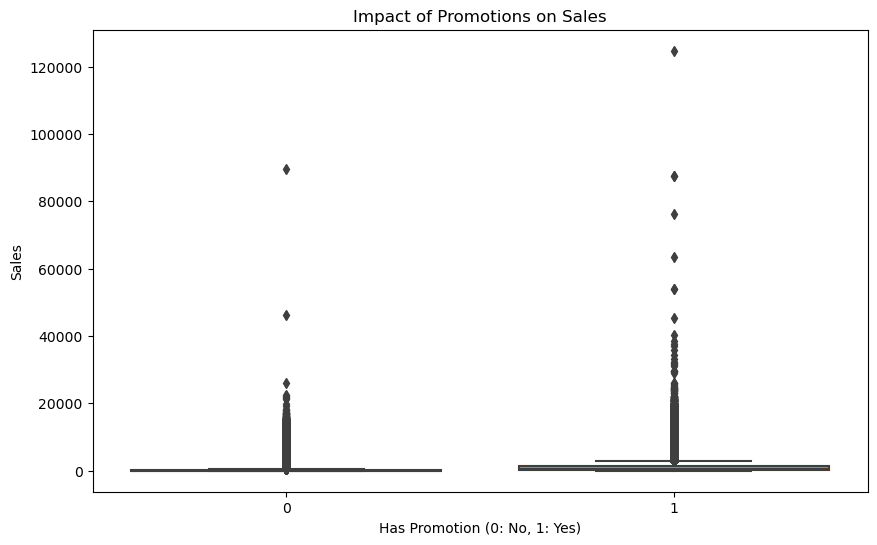

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_promotion', y='sales', data=train_df)
plt.title('Impact of Promotions on Sales')
plt.xlabel('Has Promotion (0: No, 1: Yes)')
plt.ylabel('Sales')
plt.show()

More variability during promotion. Fewer outliers during no promotion.

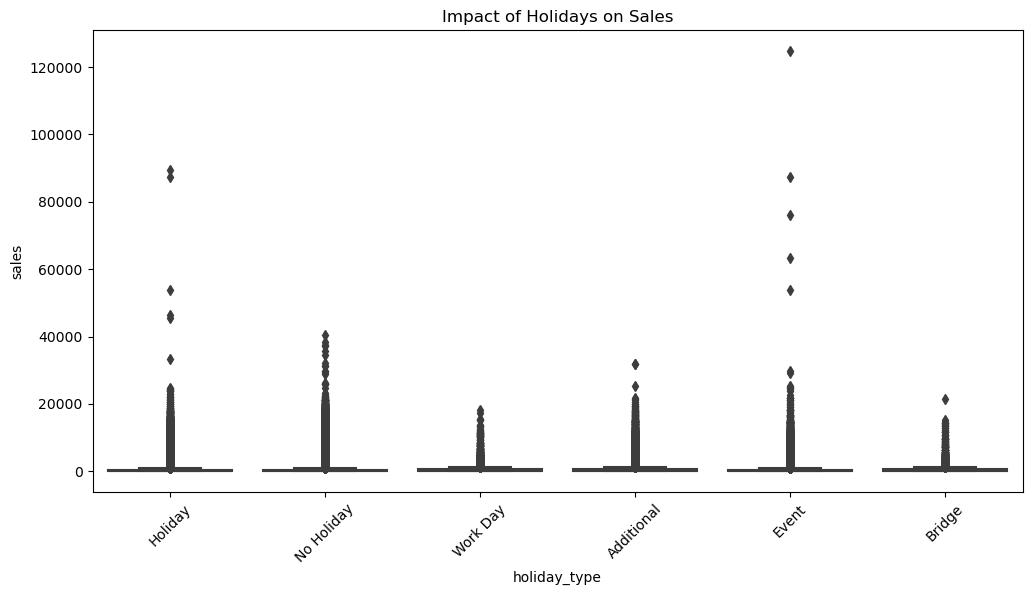

In [48]:
train_df['holiday_type'] = train_df['holiday_type'].replace('TransferredHoliday', 'Holiday')


plt.figure(figsize=(12, 6))
sns.boxplot(x='holiday_type', y='sales', data=train_df)
plt.title('Impact of Holidays on Sales')
plt.xticks(rotation=45)
plt.show()

Lots of spikes on Holiday and Event days, indicating higher sales potential.

In [50]:
train_df.dtypes

id                          int64
date               datetime64[ns]
store_nbr                   int64
family                     object
sales                     float64
onpromotion                 int64
year                        int32
month                       int32
day                         int32
day_of_week                 int32
week_of_year               UInt32
lag_1                     float64
lag_7                     float64
rolling_mean_7            float64
rolling_mean_30           float64
city                       object
state                      object
store_type                 object
cluster                     int64
dcoilwtico                float64
holiday_type               object
has_promotion               int64
year_month              period[M]
log_sales                 float64
dtype: object

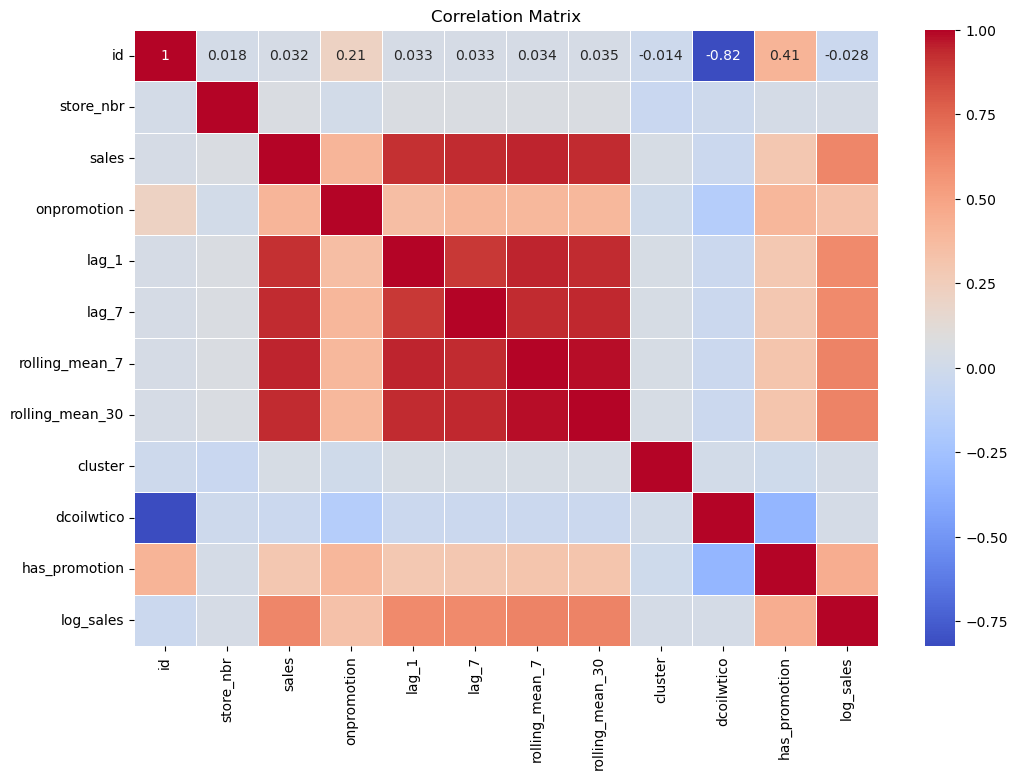

In [51]:
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Negative correlation between dcoil and has_promotion. Strong correlation between lags and rollings with sales.

In [57]:
pd.set_option('display.max_rows', None)
corr_pairs = corr_matrix.unstack().sort_values(ascending=False, key=abs)
corr_pairs = corr_pairs[corr_pairs < 1]
print(corr_pairs)

rolling_mean_30  rolling_mean_7     0.985508
rolling_mean_7   rolling_mean_30    0.985508
lag_1            rolling_mean_7     0.948318
rolling_mean_7   lag_1              0.948318
                 sales              0.946125
sales            rolling_mean_7     0.946125
lag_7            rolling_mean_30    0.940405
rolling_mean_30  lag_7              0.940405
lag_1            rolling_mean_30    0.934827
rolling_mean_30  lag_1              0.934827
lag_7            rolling_mean_7     0.934634
rolling_mean_7   lag_7              0.934634
rolling_mean_30  sales              0.934196
sales            rolling_mean_30    0.934196
                 lag_7              0.933693
lag_7            sales              0.933693
lag_1            sales              0.915447
sales            lag_1              0.915447
lag_7            lag_1              0.895825
lag_1            lag_7              0.895825
id               dcoilwtico        -0.822874
dcoilwtico       id                -0.822874
rolling_me

I would like to consider transforming other column types (city, family, state, store_type, holiday_type) into numeric, to explore relationships.

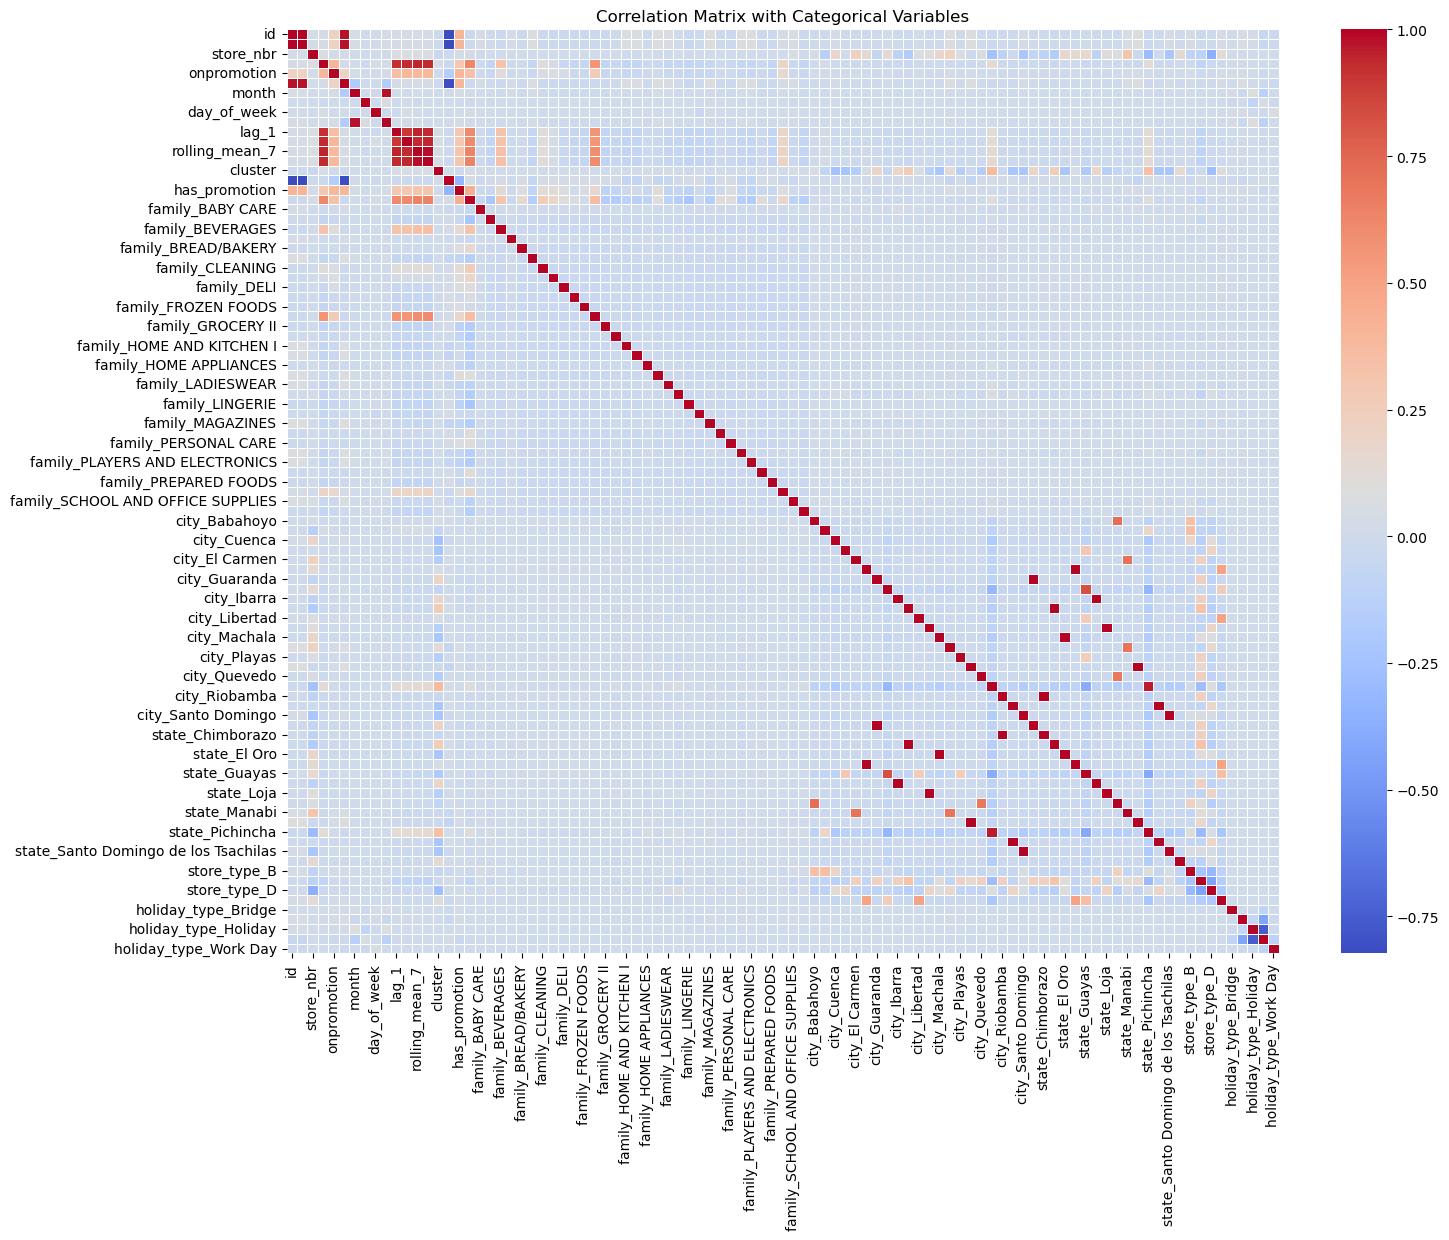

date                                  id                                      1.000000
id                                    date                                    1.000000
rolling_mean_30                       rolling_mean_7                          0.985508
rolling_mean_7                        rolling_mean_30                         0.985508
year                                  date                                    0.976786
date                                  year                                    0.976786
year                                  id                                      0.976670
id                                    year                                    0.976670
month                                 week_of_year                            0.971951
week_of_year                          month                                   0.971951
city_Quito                            state_Pichincha                         0.957716
state_Pichincha                       city_

In [61]:
categorical_columns = ['family', 'city', 'state', 'store_type', 'holiday_type']

#One-hot encoding for categorical features
train_df_encoded = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)

train_df_encoded = train_df_encoded.drop(columns=['year_month'])

#calculate correlation matrix with new features
corr_matrix = train_df_encoded.corr()

#plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix with Categorical Variables')
plt.show()

#expand the correlation matrix and sort by absolute value
corr_pairs = corr_matrix.unstack().sort_values(ascending=False, key=abs)
corr_pairs = corr_pairs[corr_pairs < 1]
print(corr_pairs)